# 행정동 PET 배출량 다중회귀분석

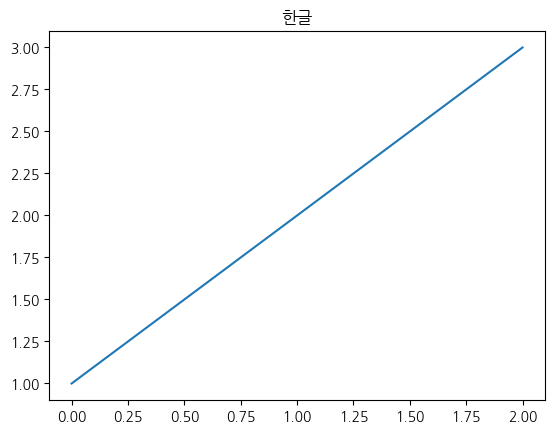

In [2]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

### 데이터 로드 & 파생변수 생성

In [4]:
df = pd.read_csv('./for_model_total.csv')

# 연령대 40, 50 평균 합 / 3, 4, 5인가구 >> 다인가구 / 일반 + 휴게 + 제과점 >> 골목먹거리
df['연령대2030_거주인구수'] = df['연령대_20_거주인구수'] + df['연령대_30_거주인구수']
df['연령대4050_거주인구수'] = df['연령대_40_거주인구수'] + df['연령대_50_거주인구수']
df['5인이하_다인가구'] = df['3인가구']+df['4인가구']+df['5인가구']
df['골목먹거리'] = df['일반음식점'] + df['휴게음식점'] + df['제과점영업']
df['주점'] = df['유흥주점영업'] + df['단란주점']
df['골목먹거리_주점합'] = df['골목먹거리'] + df['주점']

# 젊은층 비율
df['2030거주비율_40이상대비'] = df['연령대2030_거주인구수']/df['연령대4050_거주인구수']
df['다인가구대비_1인가구비율'] = df['1인가구'] / df['5인이하_다인가구']
df['2040_생산_생활인구합'] = df['연령대20_평균']+df['연령대30_평균']+df['연령대40_평균']
df['주요경제활동인구_생활인구수'] = df['연령대20_평균']+df['연령대30_평균']+df['연령대40_평균']+df['연령대50_평균']

print(df.columns)
df.head(2)

Index(['자치구', '월평균_총생활인구수', '연령대0_평균', '연령대10_평균', '연령대20_평균', '연령대30_평균',
       '연령대40_평균', '연령대50_평균', '연령대60_평균', '연령대70이상_평균', '1인가구', '2인가구',
       '3인가구', '4인가구', '5인가구', '6인가구', '7인 이상 가구', '연령대_100', '연령대_0_거주인구수',
       '연령대_10_거주인구수', '연령대_20_거주인구수', '연령대_30_거주인구수', '연령대_40_거주인구수',
       '연령대_50_거주인구수', '연령대_60_거주인구수', '연령대_70_거주인구수', '연령대_80_거주인구수',
       '연령대_90_거주인구수', '유흥주점영업', '단란주점', '제과점영업', '집단급식소', '일반음식점', '휴게음식점',
       'PET 총량', '연령대2030_거주인구수', '연령대4050_거주인구수', '5인이하_다인가구', '골목먹거리', '주점',
       '골목먹거리_주점합', '2030거주비율_40이상대비', '다인가구대비_1인가구비율', '2040_생산_생활인구합',
       '주요경제활동인구_생활인구수'],
      dtype='object')


,자치구,월평균_총생활인구수,연령대0_평균,연령대10_평균,연령대20_평균,연령대30_평균,연령대40_평균,연령대50_평균,연령대60_평균,연령대70이상_평균,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인 이상 가구,연령대_100,연령대_0_거주인구수,연령대_10_거주인구수,연령대_20_거주인구수,연령대_30_거주인구수,연령대_40_거주인구수,연령대_50_거주인구수,연령대_60_거주인구수,연령대_70_거주인구수,연령대_80_거주인구수,연령대_90_거주인구수,유흥주점영업,단란주점,제과점영업,집단급식소,일반음식점,휴게음식점,PET 총량,연령대2030_거주인구수,연령대4050_거주인구수,5인이하_다인가구,골목먹거리,주점,골목먹거리_주점합,2030거주비율_40이상대비,다인가구대비_1인가구비율,2040_생산_생활인구합,주요경제활동인구_생활인구수
0,강남구,5.892936e+08,3.542718e+07,5.912810e+07,9.170488e+07,1.144680e+08,1.135606e+08,7.744400e+07,5.143368e+07,4.612720e+07,71046,53275,44046,37272,7736,1488,371,154.416667,33177.916667,54883.000000,71170.750000,76109.333333,92528.833333,77089.250000,58011.583333,32993.833333,11749.000000,2105.083333,2782.0,3645.0,6117.0,5555.0,165890.0,50825.0,2680.0,147280.083333,169618.083333,89054,222832.0,6427.0,229259.0,0.868304,0.797786,3.197335e+08,3.971775e+08
1,강동구,3.672376e+08,2.948711e+07,3.649162e+07,4.277418e+07,5.701898e+07,6.077971e+07,5.486420e+07,4.517363e+07,4.064814e+07,50316,47737,39447,31455,6659,1241,282,125.166667,29137.083333,33109.333333,53416.083333,62451.666667,64231.250000,62544.083333,57224.666667,27460.583333,9633.416667,1619.916667,1606.0,1097.0,1855.0,3263.0,47030.0,13467.0,2886.3,115867.750000,126775.333333,77561,62352.0,2703.0,65055.0,0.913961,0.648728,1.605729e+08,2.154371e+08


### 상관계수 확인

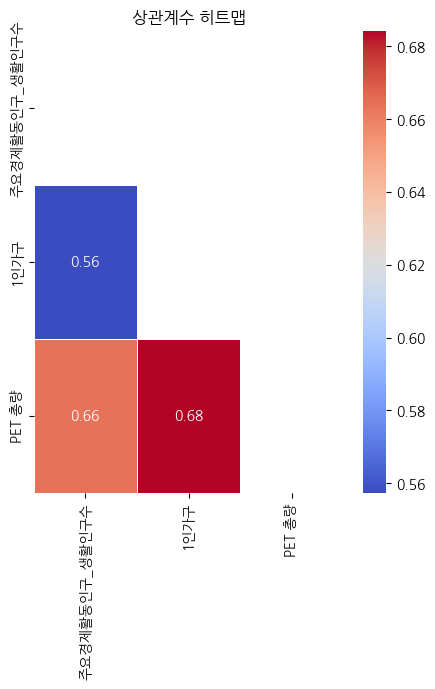

In [5]:
# feature engineering
import seaborn as sns
import matplotlib.pyplot as plt

features = ['주요경제활동인구_생활인구수','1인가구', 'PET 총량']
x_features = features[:-1]
df = df[features]

# 상관계수 행렬 계산
correlation_matrix = df.corr()

# 상관계수 행렬의 반만 가리기
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 상관계수가 0.5를 넘는 값만 추출
# high_corr_values = correlation_matrix[abs(correlation_matrix) > 0.8]

# 히트맵 시각화
plt.figure(figsize=(5, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = mask)
plt.title("상관계수 히트맵")
plt.show()

### 다중공선성(독립변수만)

In [6]:
# 다중공선성
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
X = df[x_features]
y = df['PET 총량']

# VIF를 계산합니다.
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 값을 출력합니다.
print(vif)

         Features       VIF
0  주요경제활동인구_생활인구수  9.527785
1            1인가구  9.527785


### 다중회귀모델

In [9]:
# 주성분 분석 없이 회귀
X = df[x_features]
y = df['PET 총량']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

# 상수 (절편) 항 추가
X_train_const = sm.add_constant(X_train)

# OLS(Ordinary Least Squares) 모델을 생성하고 학습
simple_model = sm.OLS(y_train, X_train_const).fit()

# 회귀 계수 확인
coefficients = simple_model.params
print("회귀 계수 (coefficients):")
print(coefficients)

# 모델 평가 (RMSE 및 MAE)
X_test_const = sm.add_constant(X_test)
y_pred = simple_model.predict(X_test_const)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}\n")
print('--'.center(100, '-'))

# 여러 모델 중에서 가장 낮은 AIC 또는 BIC 값을 가진 모델을 선택하는 것이 일반적으로 더 적합한 모델로 간주
simple_model.summary()

회귀 계수 (coefficients):
const             64.324935
주요경제활동인구_생활인구수     0.000004
1인가구               0.013094
dtype: float64
RMSE: 187.85921516911492
MAE: 183.75974337220092

----------------------------------------------------------------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PET 총량   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     13.45
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           0.000230
Time:                        23:00:39   Log-Likelihood:                -164.78
No. Observations:                  22   AIC:                             335.6
Df Residuals:                      19   BIC:                             338.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             64.3249    307.136      0.209      0.836    -578.517     707.167
주요경제활동인구_생활인구수  3.956e-06   1.71e-06      2.318      0.032    3.83e-07    7.53e-06
1인가구               0.0131      0.005      2.535      0.020       0.002       0.024
==============================================================================
Omnibus:                        8.132   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                6.600
Skew:                           0.793   Prob(JB):                       0.0369
Kurtosis:                       5.164   Cond. No.                     6.34e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 #### [채택]statsmodel

In [291]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# PCA 모델 생성
rg_pca = PCA(n_components=3)

# 주성분 분석을 위한 데이터 변환
X_pca = rg_pca.fit_transform(df[x_features])
y = scaled_df['PET 총량']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 상수 (절편) 항 추가
X_train_const = sm.add_constant(X_train)

# OLS(Ordinary Least Squares) 모델을 생성하고 학습
model = sm.OLS(y_train, X_train_const).fit()

# 회귀 계수 확인
coefficients = model.params
print("회귀 계수 (coefficients):")
print(coefficients)

# 모델 평가 (RMSE 및 MAE)
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}\n")
print('--'.center(100, '-'))

# 여러 모델 중에서 가장 낮은 AIC 또는 BIC 값을 가진 모델을 선택하는 것이 일반적으로 더 적합한 모델로 간주
model.summary()

회귀 계수 (coefficients):
const    1580.669683
x1          0.000003
x2         -0.008244
x3       2342.277444
dtype: float64
RMSE: 719.2590429999143
MAE: 571.5450203675558

----------------------------------------------------------------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PET 총량   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     8.703
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00118
Time:                        21:51:08   Log-Likelihood:                -147.41
No. Observations:                  20   AIC:                             302.8
Df Residuals:                      16   BIC:                             306.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1580.6697     99.391     15.904      0.000    1369.970    1791.369
x1          2.852e-06   1.23e-06      2.313      0.034    2.38e-07    5.47e-06
x2            -0.0082      0.005     -1.690      0.110      -0.019       0.002
x3          2342.2774    776.600      3.016      0.008     695.959    3988.596
==============================================================================
Omnibus:                        0.030   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.985   Jarque-Bera (JB):                0.173
Skew:                           0.077   Prob(JB):                        0.917
Kurtosis:                       2.570   Cond. No.                     7.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""